# 1 Import Library

In [14]:
%reset -f

In [15]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/Source/run1/wrk/


# 2 Read Model

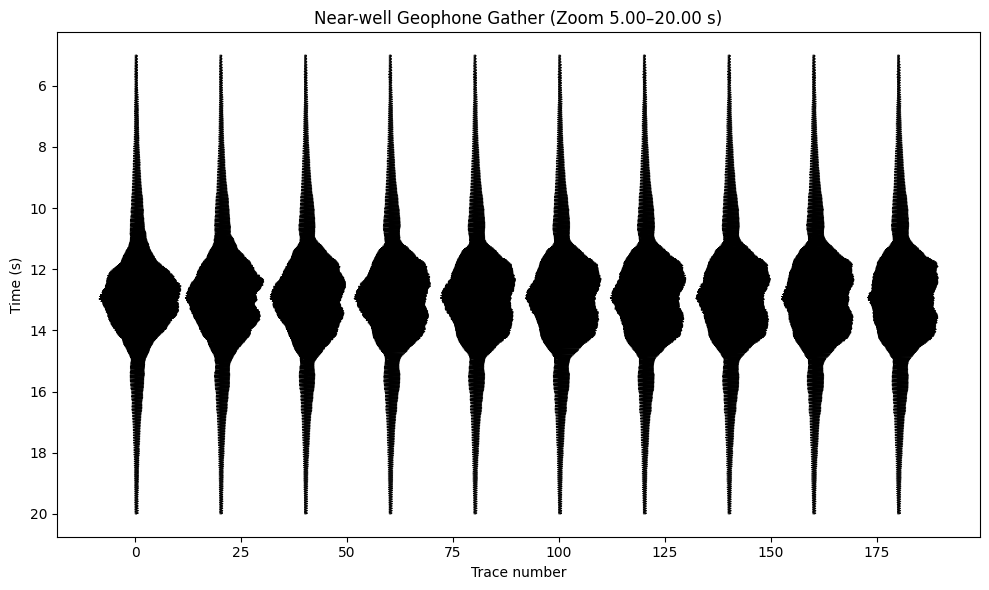

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Parameters
# -----------------------
dir_model = "./Data/"
fname1 = "geo.ch15.all.median.bin"

n_traces, n_samples = 200, 30000
dt = 0.001  # 1 ms sample interval
dtype = np.float32

# Wiggle display parameters
tmin, tmax = 5, 20   # seconds: zoom window for wavelet (adjust as needed)
decim = 20               # plot every Nth trace
scale = 0.035          # global horizontal scale factor
fill_positive = True

# -----------------------
# Load data
# -----------------------
data1 = np.fromfile(dir_model + fname1, dtype=dtype).reshape(n_traces, n_samples)
time = np.arange(n_samples) * dt

# Window
i1 = int(tmin / dt)
i2 = int(tmax / dt)
data_win = data1[:, i1:i2]
time_win = time[i1:i2]

# -----------------------
# Wiggle plot
# -----------------------
plt.figure(figsize=(10, 6))

for i in range(0, n_traces, decim):
    trace = data_win[i, :]
    x = i + trace * scale
    plt.plot(x, time_win, 'k', linewidth=0.5)
    if fill_positive:
        plt.fill_betweenx(time_win, i, x, where=(x > i), color='k', alpha=0.7)

plt.gca().invert_yaxis()
plt.xlabel("Trace number")
plt.ylabel("Time (s)")
plt.title(f"Near-well Geophone Gather (Zoom {tmin:.2f}–{tmax:.2f} s)")
plt.tight_layout()
plt.show()


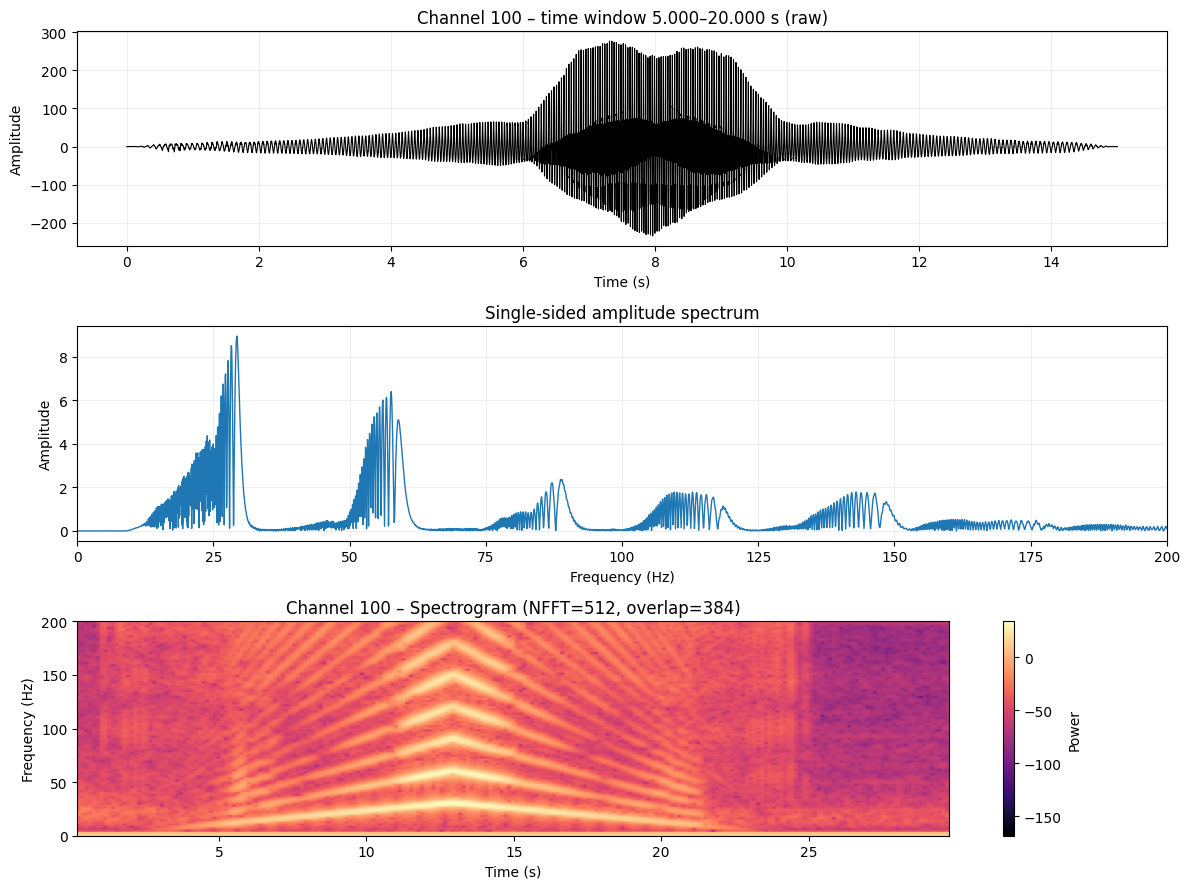

In [17]:
# Spectral Analysis

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Params you can edit
# -----------------------

ch = 100                   # channel index to analyze (0..199)
twin = (5, 20)      # time window [s] for wavelet-focused analysis
taper_frac = 0.05        # 5% cosine taper to reduce spectral leakage
nfft = None              # None => next pow2 of window length; or set e.g. 4096

# -----------------------
# Load one channel (raw)
# -----------------------
x = np.fromfile(dir_model + fname1, dtype=dtype).reshape(n_traces, n_samples)[ch]
t = np.arange(n_samples) * dt

# Window around the pulse (edit twin as needed)
i1 = int(twin[0]/dt); i2 = int(twin[1]/dt)
xw = x[i1:i2].copy()
tw = t[i1:i2] - t[i1]          # start window at 0 for plotting

# Detrend + cosine taper (no amplitude normalization)
xw -= xw.mean()
n = len(xw)
m = int(taper_frac*n)
if m > 0:
    w = np.ones(n)
    ramp = 0.5*(1 - np.cos(np.linspace(0, np.pi, m)))
    w[:m] = ramp
    w[-m:] = ramp[::-1]
    xw *= w

# -----------------------
# Amplitude spectrum (single-sided)
# -----------------------
if nfft is None:
    nfft = 1 << (n-1).bit_length()  # next pow2
X = np.fft.rfft(xw, n=nfft)
freq = np.fft.rfftfreq(nfft, d=dt)

# scale to single-sided amplitude spectrum (raw units)
# (2/N) * |FFT|; keep DC/Nyquist un-doubled
A = np.abs(X)
A *= 2.0 / n
if nfft % 2 == 0:  # even nfft, Nyquist present
    A[-1] *= 0.5
A[0] *= 0.5

# -----------------------
# Spectrogram (short-time spectrum)
# -----------------------
# Use matplotlib's specgram (no SciPy dependency)
Nwin = 512          # window length (samples) -> ~0.512 s here
Nover = int(0.75*Nwin)
plt.figure(figsize=(12,9))

# 1) time trace (windowed)
ax1 = plt.subplot(3,1,1)
ax1.plot(tw, xw, 'k', lw=0.8)
ax1.set_title(f"Channel {ch} – time window {twin[0]:.3f}–{twin[1]:.3f} s (raw)")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.grid(alpha=0.2)

# 2) amplitude spectrum
ax2 = plt.subplot(3,1,2)
ax2.plot(freq, A, lw=1.0)
ax2.set_xlim(0, 200)                # adjust band as needed (Nyquist = 1/(2*dt) = 500 Hz)
ax2.set_title("Single-sided amplitude spectrum")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Amplitude")
ax2.grid(alpha=0.2)

# 3) spectrogram
ax3 = plt.subplot(3,1,3)
Pxx, f_spec, t_spec, im = ax3.specgram(
    x, NFFT=Nwin, Fs=1.0/dt, noverlap=Nover, cmap="magma"
)
ax3.set_ylim(0, 200)                # limit frequency display
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Frequency (Hz)")
ax3.set_title(f"Channel {ch} – Spectrogram (NFFT={Nwin}, overlap={Nover})")
plt.colorbar(im, ax=ax3, label="Power")
plt.tight_layout()
plt.show()


In [35]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ========================
# # User parameters
# # ========================
# dir_model = "./Data/"
# fname = "geo.ch15.all.median.bin"

# n_traces, n_samples = 200, 30000    # data shape
# dt = 0.001                          # sample interval [s]
# dtype = np.float32

# # Pilot processing parameters
# win_s = 0.5              # half-window (seconds) around 0 lag to KEEP; total ~ 2*win_s
# use_median = True        # robust stack
# apply_taper = True       # Hann taper
# f1, f2 = 5.0, 125.0       # bandpass [Hz] for your data
# make_pilot_causal = False  # True if modeling requires a causal wavelet

# # ========================
# # Helpers
# # ========================
# def fft_bandpass(x, dt, f_lo, f_hi):
#     """
#     Zero-phase bandpass in frequency domain (no SciPy).
#     """
#     n = len(x)
#     fs = 1.0 / dt
#     nfft = int(2 ** np.ceil(np.log2(n)))
#     X = np.fft.rfft(x, n=nfft)
#     freqs = np.fft.rfftfreq(nfft, d=dt)
#     mask = (freqs >= f_lo) & (freqs <= f_hi)
#     X_filt = X * mask
#     x_filt = np.fft.irfft(X_filt, n=nfft)[:n]
#     return x_filt

# def normalize_unit_energy(x, eps=1e-12):
#     return x / (np.sqrt(np.sum(x**2)) + eps)

# def make_causal_shift(x):
#     """
#     Shift half-length to make a causal-like version from a symmetric pilot.
#     """
#     n = len(x)
#     shift = n // 2
#     y = np.zeros_like(x)
#     if shift < n:
#         y[shift:] = x[:n-shift]
#     return y

# # ========================
# # Load data
# # ========================
# path = dir_model + fname
# data = np.fromfile(path, dtype=dtype)
# if data.size != n_traces * n_samples:
#     raise ValueError(f"Data size mismatch. Expected {n_traces*n_samples}, got {data.size}. "
#                      "Check n_traces, n_samples, dtype, or file path.")
# data = data.reshape(n_traces, n_samples)

# # ========================
# # Autocorrelation per trace
# # ========================
# acfs = []
# for k in range(n_traces):
#     tr = data[k] - np.mean(data[k])                  # demean
#     ac = np.correlate(tr, tr, mode="full")           # length = 2*n_samples - 1
#     acfs.append(ac.astype(np.float64))               # keep precision in stack
# acfs = np.vstack(acfs)

# # ========================
# # Stack (median or mean)
# # ========================
# ac_stack = np.median(acfs, axis=0) if use_median else np.mean(acfs, axis=0)

# # ========================
# # Build lag axis (FULL)
# # ========================
# lags = np.arange(-n_samples + 1, n_samples) * dt
# mid = len(ac_stack) // 2

# # ========================
# # Extract central window (pilot)
# # ========================
# win = int(win_s / dt)
# i0 = mid - win
# i1 = mid + win + 1
# if i0 < 0 or i1 > len(ac_stack):
#     raise ValueError("Window exceeds ACF length. Decrease win_s or check n_samples/dt.")
# pilot = ac_stack[i0:i1].copy()
# pilot_time = lags[i0:i1]

# # ========================
# # Taper (Hann) - optional
# # ========================
# if apply_taper:
#     pilot *= np.hanning(len(pilot))

# # ========================
# # Band-limit (FFT domain)
# # ========================
# pilot = fft_bandpass(pilot, dt, f1, f2)

# # ========================
# # Normalize to unit energy
# # ========================
# pilot_unit = normalize_unit_energy(pilot)

# # ========================
# # Optional: make causal
# # ========================
# if make_pilot_causal:
#     pilot_unit = make_causal_shift(pilot_unit)
#     # pilot_time shift only for display clarity (not required otherwise)
#     pilot_time = pilot_time - pilot_time[0]

# # ========================
# # QC plots (no saving)
# # ========================

# # 1) Full stacked autocorrelation (normalized for display)
# plt.figure(figsize=(12, 3))
# ac_vis = ac_stack / (np.max(np.abs(ac_stack)) + 1e-12)
# plt.plot(lags, ac_vis, lw=0.6)
# plt.axvline(0, ls="--", lw=0.7)
# plt.title("FULL stacked autocorrelation (normalized for display)")
# plt.xlabel("Lag (s)")
# plt.ylabel("Amplitude (norm)")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# # 2) Final pilot in time
# plt.figure(figsize=(10, 3))
# plt.plot(pilot_time, pilot_unit, lw=0.9, label="Pilot (windowed+tapered+band-limited, unit energy)")
# plt.axvline(0, ls="--", lw=0.7)
# plt.title(f"Source pilot (window ±{win_s:.3f}s, band {f1:.1f}-{f2:.1f} Hz)")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 3) Pilot amplitude spectrum
# fs = 1.0 / dt
# nfft = int(2 ** np.ceil(np.log2(len(pilot_unit))))
# F = np.fft.rfft(pilot_unit, n=nfft)
# freqs = np.fft.rfftfreq(nfft, d=dt)
# amp = np.abs(F)

# plt.figure(figsize=(10, 3))
# plt.plot(freqs, amp, lw=0.9)
# plt.xlim(0, min(200.0, fs/2))
# plt.title("Pilot amplitude spectrum")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("|Amplitude|")
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# # pilot_unit (numpy array) now holds your final wavelet in memory


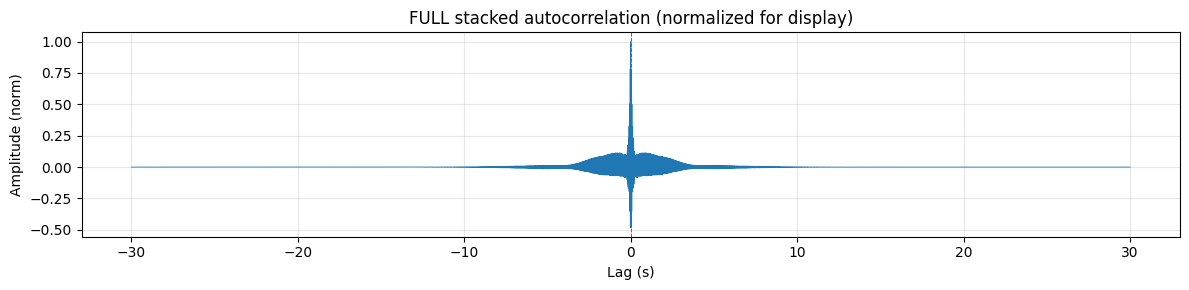

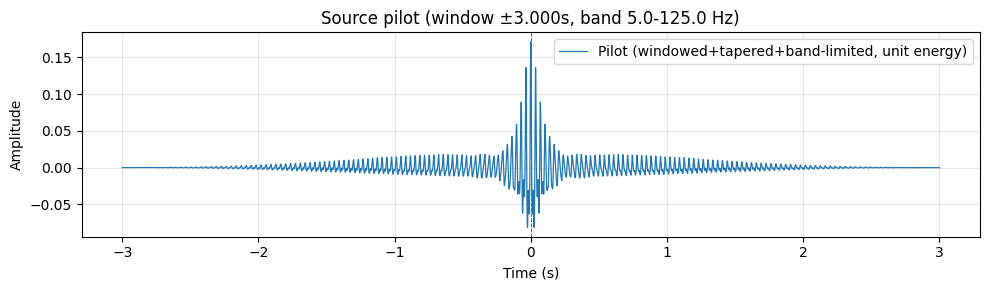

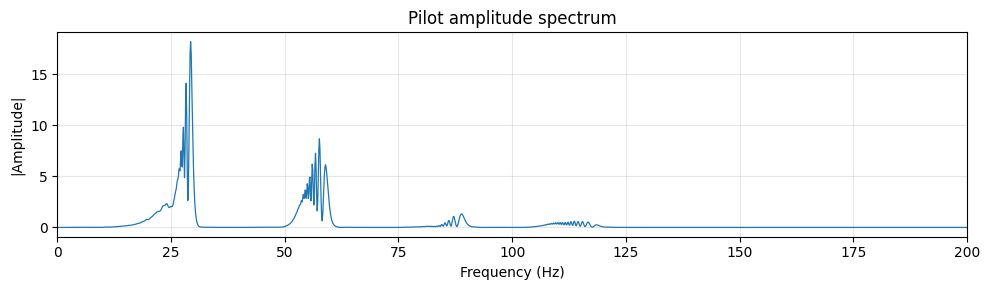

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# ========================
# User parameters
# ========================
dir_model = "./Data/"
fname = "geo.ch15.all.median.bin"

n_traces, n_samples = 200, 30000    # data shape
dt = 0.001                          # sample interval [s]
dtype = np.float32

# Pilot processing parameters
win_s = 3             # half-window (seconds) around 0 lag to KEEP; total ~ 2*win_s
use_median = True        # robust stack
apply_taper = True       # Hann taper
f1, f2 = 5.0, 125.0       # bandpass [Hz] for your data
make_pilot_causal = False  # True if modeling requires a causal wavelet

# ========================
# Helpers
# ========================
def fft_bandpass(x, dt, f_lo, f_hi):
    """
    Zero-phase bandpass in frequency domain (no SciPy).
    """
    n = len(x)
    fs = 1.0 / dt
    nfft = int(2 ** np.ceil(np.log2(n)))
    X = np.fft.rfft(x, n=nfft)
    freqs = np.fft.rfftfreq(nfft, d=dt)
    mask = (freqs >= f_lo) & (freqs <= f_hi)
    X_filt = X * mask
    x_filt = np.fft.irfft(X_filt, n=nfft)[:n]
    return x_filt

def normalize_unit_energy(x, eps=1e-12):
    return x / (np.sqrt(np.sum(x**2)) + eps)

def make_causal_shift(x):
    """
    Shift half-length to make a causal-like version from a symmetric pilot.
    """
    n = len(x)
    shift = n // 2
    y = np.zeros_like(x)
    if shift < n:
        y[shift:] = x[:n-shift]
    return y

# ========================
# Load data
# ========================
path = dir_model + fname
data = np.fromfile(path, dtype=dtype)
if data.size != n_traces * n_samples:
    raise ValueError(f"Data size mismatch. Expected {n_traces*n_samples}, got {data.size}. "
                     "Check n_traces, n_samples, dtype, or file path.")
data = data.reshape(n_traces, n_samples)

# ========================
# Autocorrelation per trace
# ========================
acfs = []
for k in range(n_traces):
    tr = data[k] - np.mean(data[k])                  # demean
    ac = np.correlate(tr, tr, mode="full")           # length = 2*n_samples - 1
    acfs.append(ac.astype(np.float64))               # keep precision in stack
acfs = np.vstack(acfs)

# ========================
# Stack (median or mean)
# ========================
ac_stack = np.median(acfs, axis=0) if use_median else np.mean(acfs, axis=0)

# ========================
# Build lag axis (FULL)
# ========================
lags = np.arange(-n_samples + 1, n_samples) * dt
mid = len(ac_stack) // 2

# ========================
# Extract central window (pilot)
# ========================
win = int(win_s / dt)
i0 = mid - win
i1 = mid + win + 1
if i0 < 0 or i1 > len(ac_stack):
    raise ValueError("Window exceeds ACF length. Decrease win_s or check n_samples/dt.")
pilot = ac_stack[i0:i1].copy()
pilot_time = lags[i0:i1]

# ========================
# Taper (Hann) - optional
# ========================
if apply_taper:
    pilot *= np.hanning(len(pilot))

# ========================
# Band-limit (FFT domain)
# ========================
pilot = fft_bandpass(pilot, dt, f1, f2)

# ========================
# Normalize to unit energy
# ========================
pilot_unit = normalize_unit_energy(pilot)

# ========================
# Optional: make causal
# ========================
if make_pilot_causal:
    pilot_unit = make_causal_shift(pilot_unit)
    # pilot_time shift only for display clarity (not required otherwise)
    pilot_time = pilot_time - pilot_time[0]

# ========================
# QC plots (no saving)
# ========================

# 1) Full stacked autocorrelation (normalized for display)
plt.figure(figsize=(12, 3))
ac_vis = ac_stack / (np.max(np.abs(ac_stack)) + 1e-12)
plt.plot(lags, ac_vis, lw=0.6)
plt.axvline(0, ls="--", lw=0.7)
plt.title("FULL stacked autocorrelation (normalized for display)")
plt.xlabel("Lag (s)")
plt.ylabel("Amplitude (norm)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Final pilot in time
plt.figure(figsize=(10, 3))
plt.plot(pilot_time, pilot_unit, lw=0.9, label="Pilot (windowed+tapered+band-limited, unit energy)")
plt.axvline(0, ls="--", lw=0.7)
plt.title(f"Source pilot (window ±{win_s:.3f}s, band {f1:.1f}-{f2:.1f} Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Pilot amplitude spectrum
fs = 1.0 / dt
nfft = int(2 ** np.ceil(np.log2(len(pilot_unit))))
F = np.fft.rfft(pilot_unit, n=nfft)
freqs = np.fft.rfftfreq(nfft, d=dt)
amp = np.abs(F)

plt.figure(figsize=(10, 3))
plt.plot(freqs, amp, lw=0.9)
plt.xlim(0, min(200.0, fs/2))
plt.title("Pilot amplitude spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Amplitude|")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# pilot_unit (numpy array) now holds your final wavelet in memory


In [42]:
n = len(pilot_unit)   # e.g. 6001
mid = n // 2          # 3000

# keep zero + positive lags
pilot_pos = pilot_unit[mid-5:-5]
time_pos  = pilot_time[mid:]


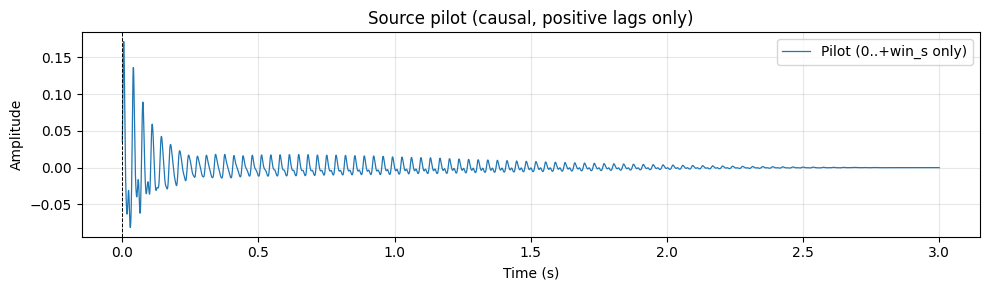

In [43]:
# ---- Plot ----
plt.figure(figsize=(10, 3))
plt.plot(time_pos, pilot_pos, lw=0.9, label="Pilot (0..+win_s only)")
plt.axvline(0, ls="--", lw=0.7, color="k")
plt.title("Source pilot (causal, positive lags only)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
pilot_pos.shape

(3001,)

In [45]:
# ========================
# Save pilot to binary only
# ========================
out_bin = "source_pilot_unit_raw.bin"

pilot_pos.astype(np.float32).tofile(out_bin)

print(f"✅ Saved pilot to {out_bin}")



✅ Saved pilot to source_pilot_unit_raw.bin


In [34]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ------------------------
# # I/O setup
# # ------------------------
# dir_model = "./Data/"
# fname = "geo.ch15.all.median.bin"
# n_traces, n_samples = 200, 30000
# dt = 0.001  # 1 ms
# dtype = np.float32

# # ------------------------
# # Load data
# # ------------------------
# data = np.fromfile(dir_model + fname, dtype=dtype).reshape(n_traces, n_samples)

# # ------------------------
# # Autocorrelation per channel
# # ------------------------
# acfs = []
# for k in range(n_traces):
#     tr = data[k] - np.mean(data[k])         # remove mean
#     ac = np.correlate(tr, tr, mode="full")  # autocorr length = 2*n_samples-1
#     acfs.append(ac)

# acfs = np.vstack(acfs)

# # ------------------------
# # Stack (median or mean)
# # ------------------------
# use_median = True
# ac_stack = np.median(acfs, axis=0) if use_median else np.mean(acfs, axis=0)

# # ------------------------
# # Build lag axis
# # ------------------------
# lags = np.arange(-n_samples+1, n_samples) * dt

# # ------------------------
# # Extract central part (pilot)
# # ------------------------
# mid = len(ac_stack) // 2
# win = int(0.5/dt)  # keep ±1 s around zero lag (adjust as needed)
# pilot = ac_stack[mid-win:mid+win+1]
# pilot_time = lags[mid-win:mid+win+1]


# # ------------------------
# # Save results
# # ------------------------
# # np.savetxt("source_pilot.txt", np.column_stack([pilot_time, pilot_unit]),
# #            fmt="%.6f", header="time(s) amplitude(unit)")
# # pilot_unit.astype(np.float32).tofile("source_pilot_unit.bin")

# # ------------------------
# # QC plots
# # ------------------------
# plt.figure(figsize=(10,3))
# plt.plot(pilot_time, pilot, 'k', lw=0.8, label="ACF stack (raw)")
# # plt.plot(pilot_time, pilot_unit, 'r', lw=0.8, label="unit energy")
# plt.title("Source pilot from 200 geophone autocorrelations")
# plt.xlabel("Lag (s)"); plt.ylabel("Amplitude")
# plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()



# # ------------------------
# # Save raw pilot as binary
# # ------------------------
# pilot.astype(np.float32).tofile("source_pilot.bin")
